# Model Disagreement Analysis

This notebook analyzes the output CSVs from the inference pipeline.

In [16]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

csv_path = "../../outputs/cifar10_val.csv" # Example path

In [17]:
try:
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} samples")
except FileNotFoundError:
    print("File not found. Run inference first.")

Loaded 20000 samples


Global Accuracy: 0.0001


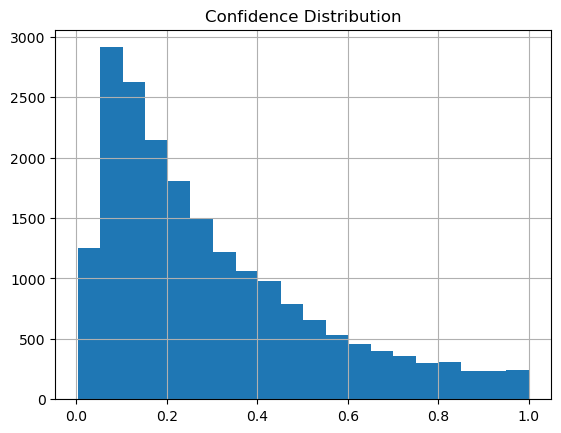

In [18]:
if 'df' in locals():
    # Accuracy
    acc = (df['prediction'] == df['ground_truth']).mean()
    print(f"Global Accuracy: {acc:.4f}")
    
    # Confidence hist
    df['confidence'].hist(bins=20)
    plt.title("Confidence Distribution")
    plt.show()

Total shared samples: 10000
Both Correct: 0
Only ResNet Correct: 1
Only MobileNet Correct: 0
Both Wrong: 9999


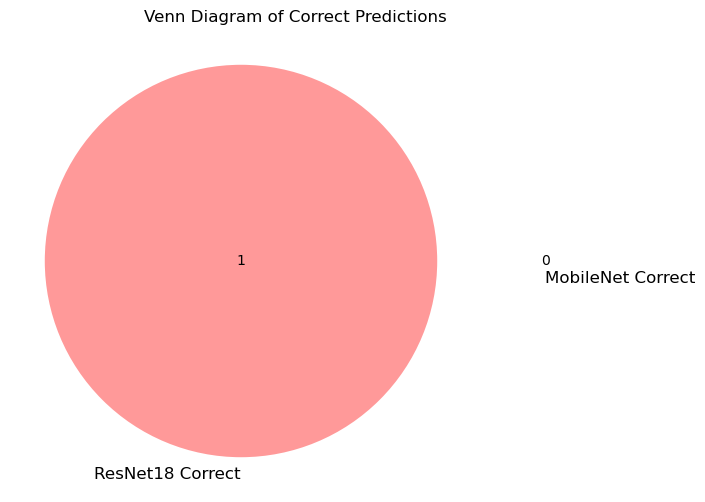

In [19]:
if 'df' in locals():
    # 1. Filter data
    df_resnet = df[df['model_id'] == 'resnet18'].copy()
    df_mobile = df[df['model_id'] == 'mobilenet_v3_large'].copy()
    
    # 2. Merge on sample_id to align predictions
    # We assume 'sample_id' is unique per image across the dataset
    merged_df = pd.merge(df_resnet, df_mobile, on='sample_id', suffixes=('_res', '_mob'))
    
    if not merged_df.empty:
        # 3. Calculate correctness
        # The ground truth should be the same, but let's use one of them
        ground_truth = merged_df['ground_truth_res']
        
        resnet_correct = merged_df['prediction_res'] == ground_truth
        mobile_correct = merged_df['prediction_mob'] == ground_truth
        
        # 4. Calculate sets
        both_correct = (resnet_correct & mobile_correct).sum()
        only_resnet = (resnet_correct & ~mobile_correct).sum()
        only_mobile = (~resnet_correct & mobile_correct).sum()
        both_wrong = (~resnet_correct & ~mobile_correct).sum()
        
        print(f"Total shared samples: {len(merged_df)}")
        print(f"Both Correct: {both_correct}")
        print(f"Only ResNet Correct: {only_resnet}")
        print(f"Only MobileNet Correct: {only_mobile}")
        print(f"Both Wrong: {both_wrong}")
        
        # 5. Plot Venn Diagram
        try:
            from matplotlib_venn import venn2
            plt.figure(figsize=(8, 6))
            # subsets = (Ab, aB, AB) -> (Only Set1, Only Set2, Intersection)
            # Here Set1 = ResNet Correct, Set2 = MobileNet Correct
            # Intersection = Both Correct
            venn2(subsets=(only_resnet, only_mobile, both_correct), 
                  set_labels=('ResNet18 Correct', 'MobileNet Correct'))
            plt.title("Venn Diagram of Correct Predictions")
            plt.show()
            
        except ImportError:
            print("\n[INFO] 'matplotlib-venn' library is not installed. Skipping Venn diagram plot.")
            print("You can install it via: pip install matplotlib-venn")
            
            # Fallback simple bar plot
            categories = ['Both Correct', 'Only ResNet', 'Only MobileNet', 'Both Wrong']
            counts = [both_correct, only_resnet, only_mobile, both_wrong]
            
            plt.figure(figsize=(8, 6))
            plt.bar(categories, counts, color=['green', 'blue', 'orange', 'red'])
            plt.title("Classification Agreement Analysis")
            plt.ylabel("Count")
            for i, v in enumerate(counts):
                plt.text(i, v + (max(counts)*0.01), str(v), ha='center')
            plt.show()
            
    else:
        print("No overlapping samples found between resnet18 and mobilenet or one of them is missing.")